# EDA_조이라이더스

## 라이브러리, CSV import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 날씨 데이터를 import
# 따로 import 다시 할거면 reset_file() 실행하지 말 것
from weather import CSVImporter as WeatherImporter
WeatherImporter.reset_file()
from pollution import CSVImporter as PollutionImporter
PollutionImporter.reset_file()
from accident import CSVImporter as AccidentImporter
AccidentImporter.reset_file()

In [3]:
# 로컬 파일 제거
WeatherImporter.reset_file()
PollutionImporter.reset_file()
AccidentImporter.reset_file()

In [4]:
# 1년 중 며칠째인지, 무슨 요일인지 추가해주는 함수
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def advanced_day(df: pd.DataFrame) -> pd.DataFrame:
    head = ["year", "month", "day"]
    new_cols = ["day_of_year", "weekday"]
    tail = [k for k in df.columns if k not in head]
    temp = pd.to_datetime(df[head])
    df[new_cols[0]] = temp.dt.dayofyear
    df[new_cols[1]] = temp.dt.weekday

    sorted_columns = head + new_cols + tail
    df = df[sorted_columns]
    return df

## Weather 데이터 분석

[데이터 출처: Kaggle](https://www.kaggle.com/datasets/alfredkondoro/seoul-historical-weather-data-2024)

In [5]:
WeatherImporter.reset_file()

In [6]:
csv_names = [
    "seoul 1994-01-01 to 1996-01-01",
    "seoul 1996-01-01 to 1998-01-01"
]

In [7]:
csv_names = []
a = 1994
b = 1996
for _ in range(94, 122, 2):
    csv_names.append(f"seoul {a}-01-01 to {b}-01-01.csv")
    a += 2
    b += 2

In [8]:
# import할 파일명을 바꾸고 싶은 경우 reset_file() 실행
weather_df = WeatherImporter.import_raw(csv_names)
weather_df = advanced_day(weather_df)

weather_df.head()

,year,month,day,day_of_year,weekday,temp,humidity,cloudy,precip,snow,windspeed,winddir,sealevelpressure,visibility,solarradiation
0,1994,1,1,1,5,-3.166667,65.9,1,0.000,0.0,5.5,115.4,1025.4,6.6,0.0
1,1994,1,2,2,6,2.333333,72.1,1,0.000,0.0,9.1,181.7,1022.2,6.9,0.0
2,1994,1,3,3,0,3.333333,68.1,1,0.000,0.0,12.8,289.5,1020.0,5.3,0.0
3,1994,1,4,4,1,-1.055556,51.2,0,0.000,0.0,11.7,301.9,1025.1,7.3,0.0
4,1994,1,5,5,2,0.611111,63.9,3,0.011,0.0,6.8,134.1,1023.9,6.2,0.0


In [9]:
weather_df = weather_df[weather_df["year"] != 2022]

In [10]:
weather_df['year'].value_counts()

year
1996    366
2000    366
2004    366
2008    366
2012    366
2016    366
2020    366
1994    365
1995    365
1997    365
1998    365
1999    365
2001    365
2002    365
2003    365
2005    365
2006    365
2007    365
2009    365
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: count, dtype: int64

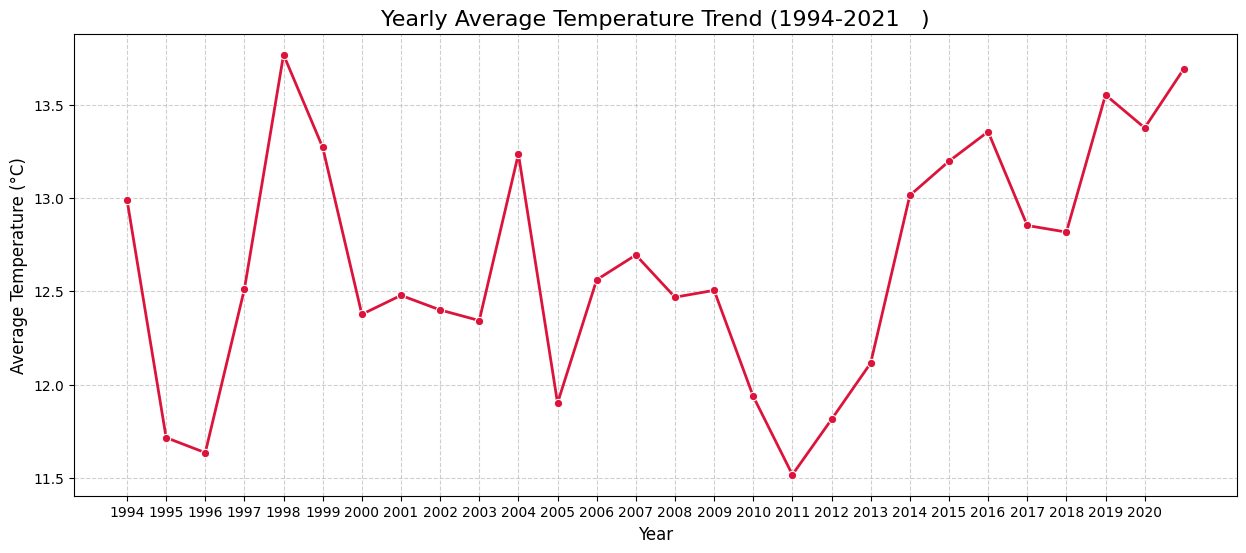

In [11]:
yearly_temp = weather_df.groupby('year')['temp'].mean()

plt.figure(figsize=(15, 6))
sns.lineplot(x=yearly_temp.index, y=yearly_temp.values, marker='o', color='crimson', linewidth=2)

plt.title('Yearly Average Temperature Trend (1994-2021   )', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1994, 2021, 1))
plt.show()

groupby('year')를 통해 연간 데이터의 평균값을 산출하고, 이를 seaborn의 lineplot을 활용해 시각화함으로써 기온의 상승 혹은 하락 경향성을 분석하는 전형적인 시계열 EDA 과정

전체 평균은 약 11.6℃ ~ 13.8℃ -> 큰 급락 없이 비교적 안정적

2013 이후 점진적 상승

2014-2021은 이전보다 높은 평균 유지, 특히 2019-2021은 최고 수준

장기적으로 보면 완만한 상승 추세

2010년 이후 평균기온이 전반적으로 상승

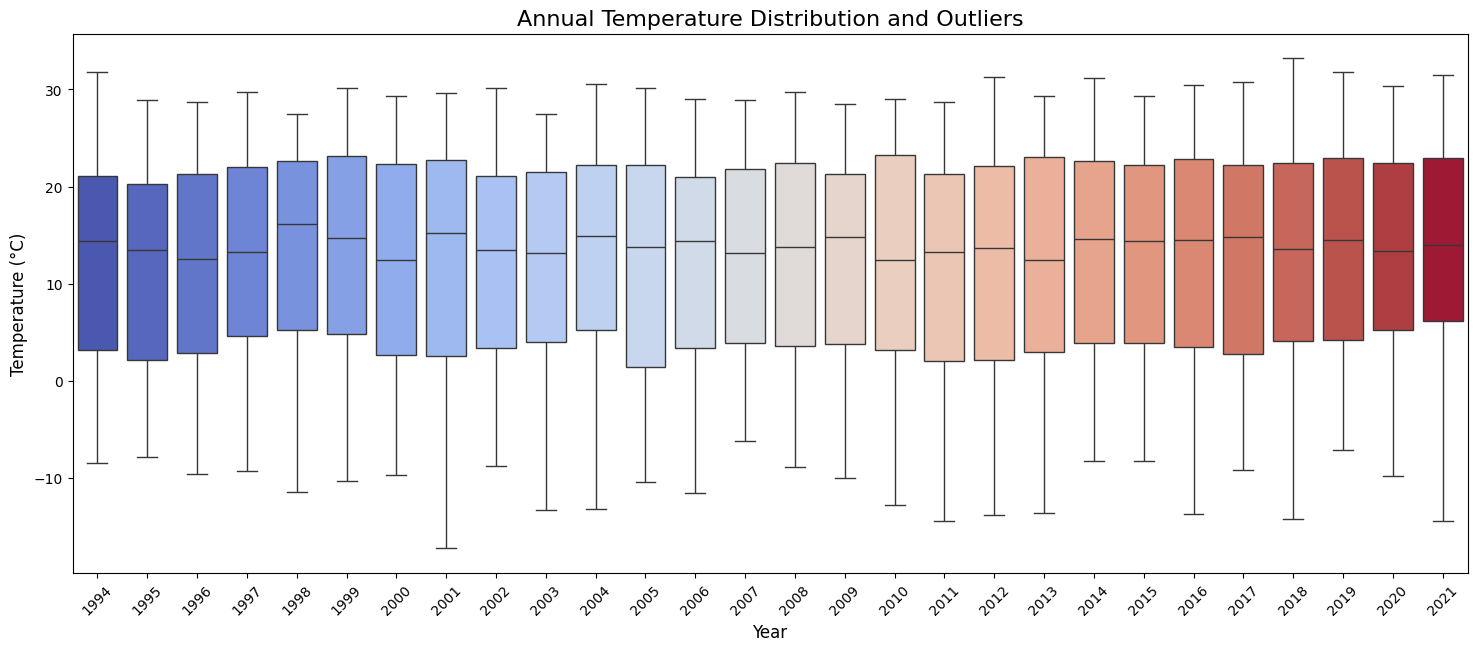

In [12]:
plt.figure(figsize=(18, 7))

sns.boxplot(data=weather_df, x='year', y='temp', hue='year', palette='coolwarm', legend=False)

plt.title('Annual Temperature Distribution and Outliers', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

연도별 기온 데이터의 중앙값과 분포 범위, 이상치를 박스 형태로 시각화하여 각 해의 기온 변동성 및 폭염·한파와 같은 극단적 기온 발생 현황을 비교 분석

모든 연도에서 박스 높이가 거의 일정 -> 계절 변동 폭은 비슷

중앙값이 2013 이후 조금 위로 이동 -> 평균 상승과 일치

극단값(최저/최고)은 큰 차이 없음 -> 변동성은 유지되지만 중심이 올라감

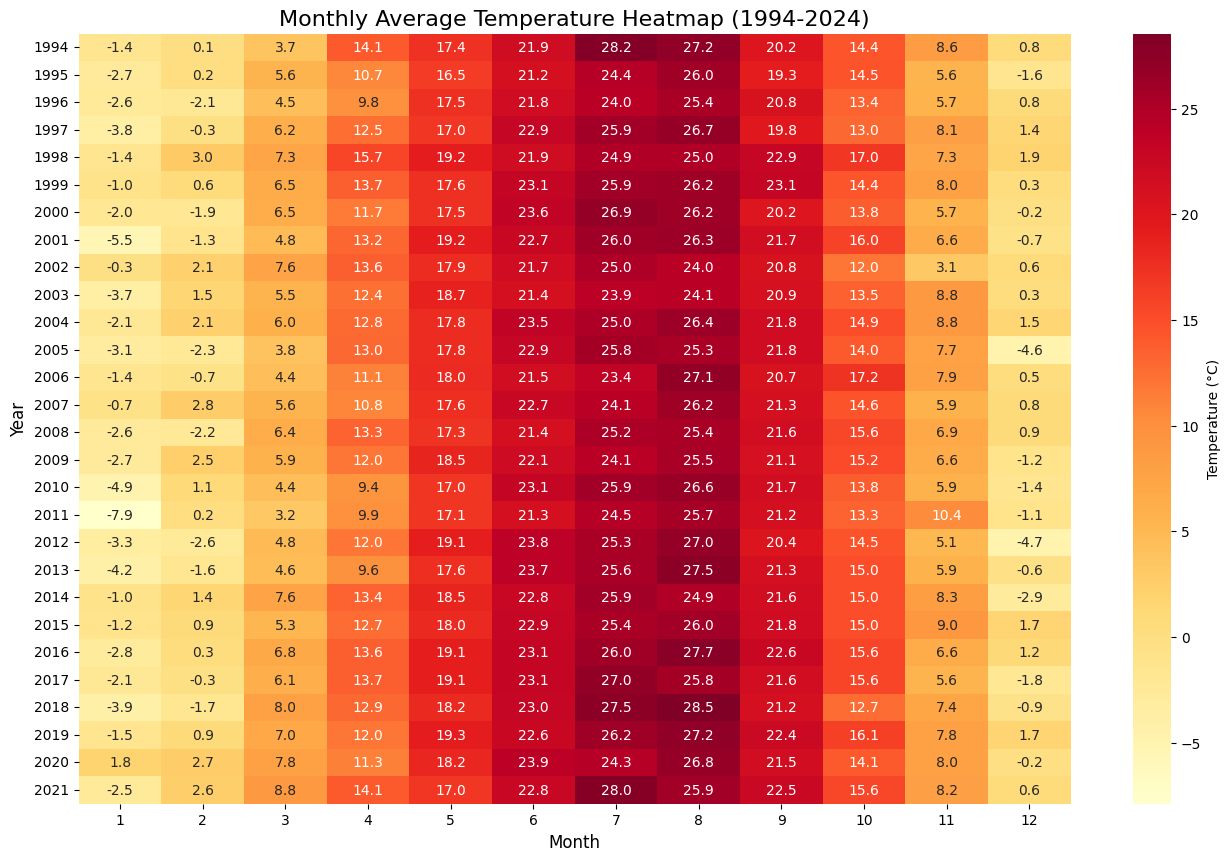

In [13]:
# 연도와 월을 기준으로 피벗 테이블 생성
temp_pivot = weather_df.pivot_table(index='year', columns='month', values='temp', aggfunc='mean')

plt.figure(figsize=(16, 10))
sns.heatmap(temp_pivot, annot=True, fmt=".1f", cmap='YlOrRd', cbar_kws={'label': 'Temperature (°C)'})

plt.title('Monthly Average Temperature Heatmap (1994-2024)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.show()

연도별·월별 평균 기온을 2차원 평면의 색상 변화로 시각화하여, 지난 30년간의 계절적 패턴과 특정 시기의 기온 상승 추세를 한눈에 파악하기 위한 피벗 테이블

<Axes: >

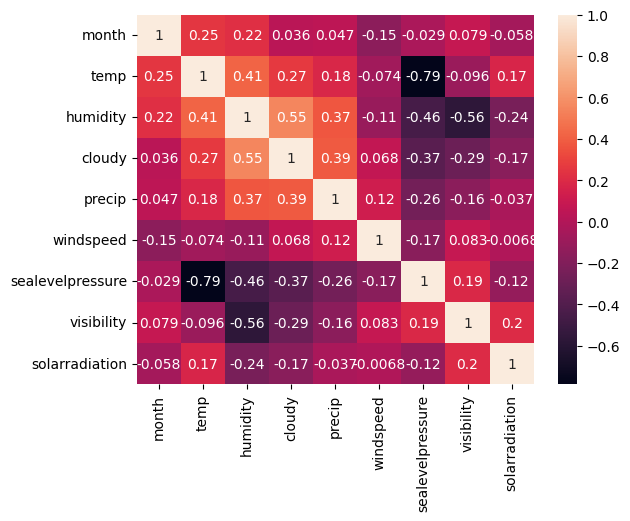

In [14]:
target_cols = ['month', 'temp', 'humidity', 'cloudy', 'precip', 'windspeed', 'sealevelpressure', 'visibility', 'solarradiation']
heat_df = weather_df[target_cols]
sns.heatmap(heat_df.corr(), annot=True)

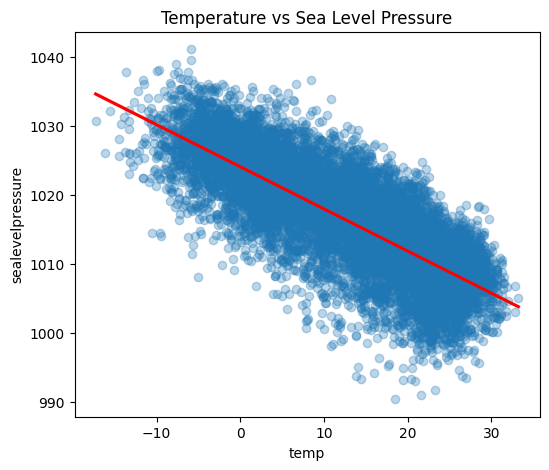

In [15]:
# 기온이 높을수록 기압은 낮아지는 경향
plt.figure(figsize=(6,5))

sns.regplot(
    data=weather_df,
    x="temp",
    y="sealevelpressure",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"}
)

plt.title("Temperature vs Sea Level Pressure")
plt.show()

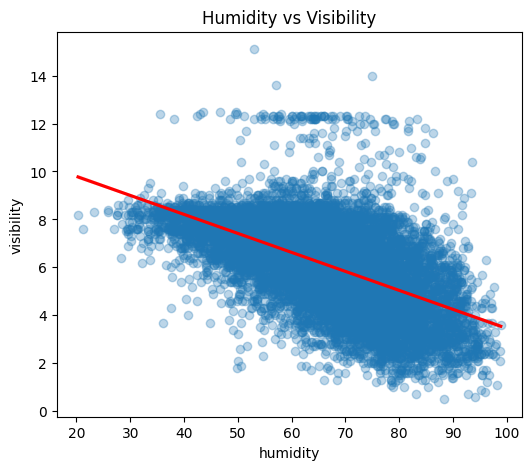

In [16]:
# 습도 증가 -> 가시거리 감소
plt.figure(figsize=(6,5))

sns.regplot(
    data=weather_df,
    x="humidity",
    y="visibility",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"}
)

plt.title("Humidity vs Visibility")
plt.show()

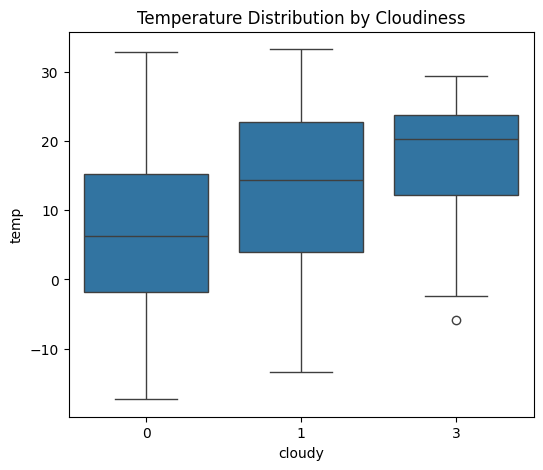

In [17]:
# 흐림 정도에 따른 기온 분포 차이
plt.figure(figsize=(6,5))

sns.boxplot(
    data=weather_df,
    x="cloudy",
    y="temp"
)

plt.title("Temperature Distribution by Cloudiness")
plt.show()

<Axes: xlabel='month', ylabel='temp'>

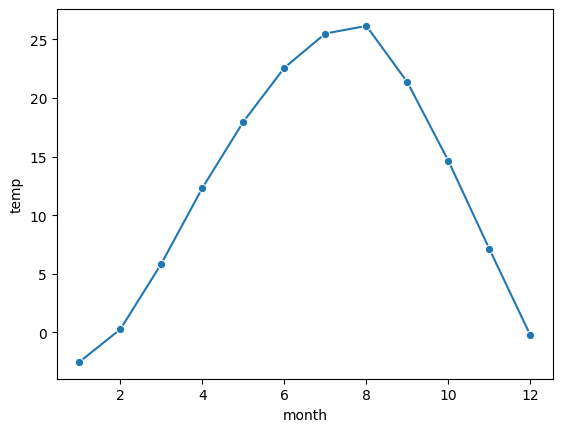

In [18]:
# 계절성 시각화
monthly_temp = weather_df.groupby("month")["temp"].mean().reset_index()

sns.lineplot(data=monthly_temp, x="month", y="temp", marker="o")

## Pollution 데이터 분석

[데이터 출처: Kaggle](https://www.kaggle.com/datasets/williamhyun/seoulairqualityhistoricdata)

In [19]:
PollutionImporter.reset_file()

In [20]:
# 년도를 바꾸고 싶은 경우 reset_file() 실행
# -1, -1 하면 전체 기간
pollution_df = PollutionImporter.import_raw(-1, -1)
pollution_df = advanced_day(pollution_df)
pollution_df.head()

,year,month,day,day_of_year,weekday,so2,so2_level,no2,no2_level,co,co_level,o3,o3_level,pm10,pm10_level,pm2.5,pm2.5_level
0,1988,1,1,1,4,0.19,3,0.03,0,6.74,1,0.01,0,NaN,NaN,NaN,NaN
1,1988,1,2,2,5,0.15,2,0.03,0,4.33,1,0.01,0,NaN,NaN,NaN,NaN
2,1988,1,3,3,6,0.15,2,0.03,0,5.72,1,0.00,0,NaN,NaN,NaN,NaN
3,1988,1,4,4,0,0.12,2,0.03,0,3.30,1,0.01,0,NaN,NaN,NaN,NaN
4,1988,1,5,5,1,0.16,3,0.03,0,5.31,1,0.02,0,NaN,NaN,NaN,NaN


<Axes: >

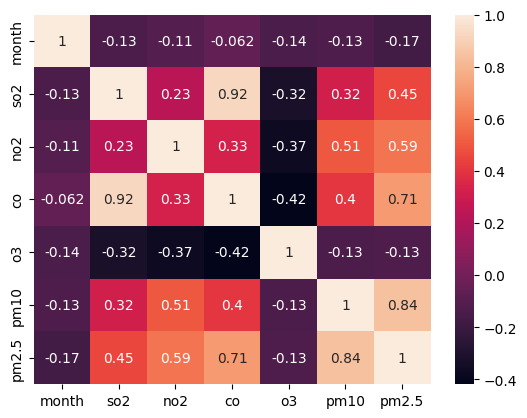

In [21]:
target_cols = ['month', 'so2', 'no2', 'co', 'o3', 'pm10', 'pm2.5']
heat_df = pollution_df[target_cols]
sns.heatmap(heat_df.corr(), annot=True)

In [22]:
pol_df_n = pollution_df[
    (pollution_df["year"] > 2000) |
    ((pollution_df["year"] == 2000) & (pollution_df["month"] > 2)) |
    ((pollution_df["year"] == 2000) & (pollution_df["month"] == 2) & (pollution_df["day"] >= 11))
]
pol_df_n

,year,month,day,day_of_year,weekday,so2,so2_level,no2,no2_level,co,co_level,o3,o3_level,pm10,pm10_level,pm2.5,pm2.5_level
4368,2000,2,11,42,4,0.01,0,0.04,1,1.09,0,0.01,0,63.09,1,55.83,2
4369,2000,2,12,43,5,0.01,0,0.05,1,1.41,0,0.01,0,104.54,2,121.88,3
4370,2000,2,13,44,6,0.01,0,0.05,1,1.54,0,0.01,0,124.76,2,163.60,3
4371,2000,2,14,45,0,0.01,0,0.03,0,0.98,0,0.02,0,65.98,1,77.60,3
4372,2000,2,15,46,1,0.01,0,0.03,0,0.90,0,0.02,0,47.60,1,21.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12343,2021,12,27,361,0,0.00,0,0.04,1,0.63,0,0.01,0,31.60,1,17.98,1
12344,2021,12,28,362,1,0.00,0,0.05,1,0.87,0,0.00,0,50.67,1,36.39,2
12345,2021,12,29,363,2,0.00,0,0.04,1,0.80,0,0.01,0,61.28,1,44.07,2
12346,2021,12,30,364,3,0.00,0,0.02,0,0.41,0,0.02,0,28.10,0,13.79,0


In [23]:
# 2000년 2월 이후 중간중간 4개의 결측치는 수가 적어서 월별 평균으로 계산하여 결측치를 채우도록 함.
import numpy as np
import pandas as pd

# =========================
# 0) 설정
# =========================
day_group = ["year", "month", "day"]     # 일별 그룹
month_group = ["year", "month"]          # 월별 그룹

# 일별 평균으로 채울 컬럼들 (pm2.5 제외)
day_fill_cols = ["so2", "no2", "co", "o3", "pm10"]

# 월별 평균으로 채울 컬럼 (pm2.5만)
pm25_col = "pm2.5"

# pm2.5 수준 구간/라벨/매핑
pm25_bins = [-np.inf, 15, 35, 75, np.inf]
pm25_labels = ["좋음", "보통", "나쁨", "매우나쁨"]
pm25_mapping = {"좋음": 0, "보통": 1, "나쁨": 2, "매우나쁨": 3}


# pm2.5 -> "월별 평균"으로 NaN 채우기
pol_df_n[pm25_col] = (
    pol_df_n.groupby(month_group)[pm25_col]
            .transform(lambda s: s.fillna(s.mean()))
)

# (선택) 혹시 월 전체가 NaN인 달이 있어 평균도 NaN이면, 전체 평균으로 마지막 한 번 더 채우기
pol_df_n[pm25_col] = pol_df_n[pm25_col].fillna(pol_df_n[pm25_col].mean())


# =========================
# 2) pm2.5_level 만들고 숫자로 인코딩
# =========================
pol_df_n["pm2.5_level"] = pd.cut(pol_df_n[pm25_col], bins=pm25_bins, labels=pm25_labels)

# 라벨 -> 숫자(0~3) 매핑
pol_df_n["pm2.5_level"] = pol_df_n["pm2.5_level"].map(pm25_mapping).astype(int)


# =========================
# 3) 확인
# =========================
print("pm2.5 결측치 개수:", pol_df_n["pm2.5"].isna().sum())
print("pm2.5_level 결측치 개수:", pol_df_n["pm2.5_level"].isna().sum())
pol_df_n

pm2.5 결측치 개수: 0
pm2.5_level 결측치 개수: 0


,year,month,day,day_of_year,weekday,so2,so2_level,no2,no2_level,co,co_level,o3,o3_level,pm10,pm10_level,pm2.5,pm2.5_level
4368,2000,2,11,42,4,0.01,0,0.04,1,1.09,0,0.01,0,63.09,1,55.83,2
4369,2000,2,12,43,5,0.01,0,0.05,1,1.41,0,0.01,0,104.54,2,121.88,3
4370,2000,2,13,44,6,0.01,0,0.05,1,1.54,0,0.01,0,124.76,2,163.60,3
4371,2000,2,14,45,0,0.01,0,0.03,0,0.98,0,0.02,0,65.98,1,77.60,3
4372,2000,2,15,46,1,0.01,0,0.03,0,0.90,0,0.02,0,47.60,1,21.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12343,2021,12,27,361,0,0.00,0,0.04,1,0.63,0,0.01,0,31.60,1,17.98,1
12344,2021,12,28,362,1,0.00,0,0.05,1,0.87,0,0.00,0,50.67,1,36.39,2
12345,2021,12,29,363,2,0.00,0,0.04,1,0.80,0,0.01,0,61.28,1,44.07,2
12346,2021,12,30,364,3,0.00,0,0.02,0,0.41,0,0.02,0,28.10,0,13.79,0


## 월별 미세먼지 level 분포 비율

- 2월이 가장 높은 수치, 8월이 가장 낮은 수치를 보인다.
- 이유:
| 계절 | 월 | PM2.5 수준 경향 | 주요 원인 | 핵심 해석 |
|---|---|---|---|---|
| 겨울 | 12~2월 | 나쁨 비율 증가 | 난방 연소 증가(석탄, LNG, 보일러), 대기 정체, 중국발 영향 | 연소 배출 증가와 대기 정체가 동시에 작용하여 PM2.5 농도가 높아지는 시기 |
| 봄 | 3~5월 | 나쁨 지속 | 황사 유입, 산업 배출 지속 | 황사로 PM10이 증가하면서 PM2.5도 함께 상승하는 경향 |
| 여름 | 6~9월 | 좋음 비율 증가 | 강수에 의한 세정 효과, 대기 혼합 활발 | 강수와 대기 순환으로 PM2.5 농도가 낮아지는 시기 (단, 오존은 증가) |
| 가을 | 10~11월 | 다시 증가 시작 | 난방 시작, 대기 안정화 | 겨울로 넘어가며 오염 축적 환경 형성 시작 |

- 결론:  PM2.5 농도는 계절별 기상 조건과 연소 활동의 영향을 크게 받는다.
겨울에는 난방 연소 증가와 대기 정체로 인해 농도가 상승하며,
여름에는 강수와 대기 혼합으로 농도가 감소한다.
봄에는 황사 영향으로 높은 수준이 유지되며,
가을에는 다시 오염 축적 환경이 형성되기 시작한다./ PM2.5는 배출량보다 기상 조건 영향을 강하게 받는 계절성 오염 물질이다.

<Figure size 1000x500 with 0 Axes>

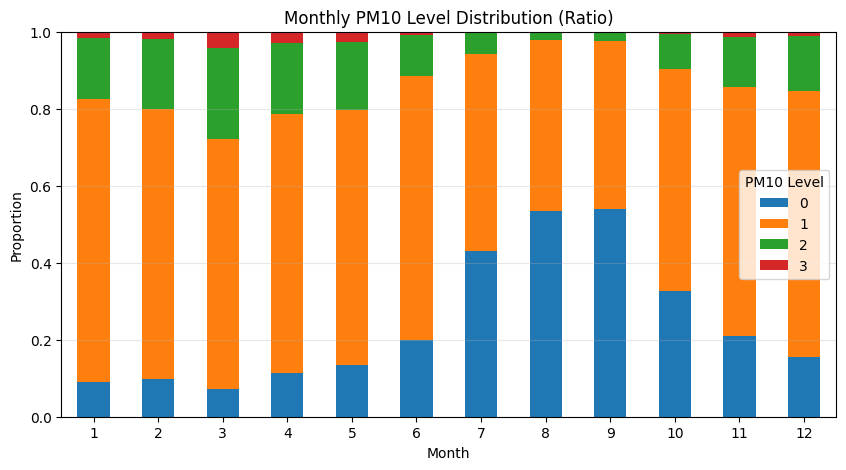

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 미세먼지
ratio_df1 = pd.crosstab(
    pol_df_n["month"],
    pol_df_n["pm10_level"],
    normalize="index"
)

plt.figure(figsize=(10,5))

ratio_df1.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5)
)

plt.title("Monthly PM10 Level Distribution (Ratio)")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.legend(title="PM10 Level")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)

plt.show()

<Figure size 1000x500 with 0 Axes>

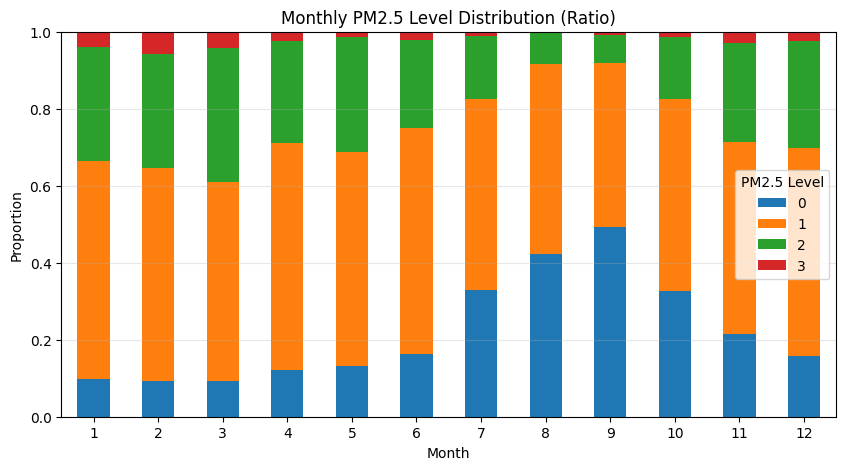

In [25]:
# 초미세먼지
ratio_df = pd.crosstab(
    pol_df_n["month"],
    pol_df_n["pm2.5_level"],
    normalize="index"
)

plt.figure(figsize=(10,5))

ratio_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5)
)

plt.title("Monthly PM2.5 Level Distribution (Ratio)")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.legend(title="PM2.5 Level")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)

plt.show()

# 연도별 평균 미세먼지

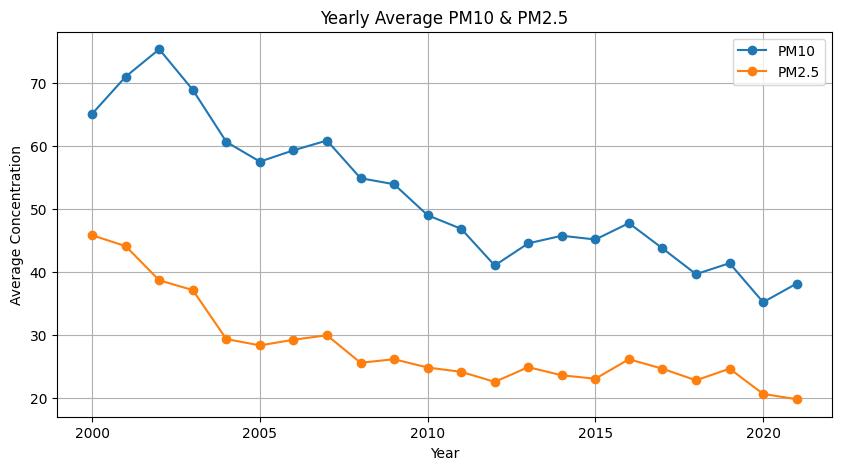

In [26]:
import matplotlib.pyplot as plt

# 연도별 평균
yearly_mean = pol_df_n.groupby("year")[["pm10", "pm2.5"]].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly_mean.index, yearly_mean["pm10"], marker="o")
plt.plot(yearly_mean.index, yearly_mean["pm2.5"], marker="o")

plt.xlabel("Year")
plt.ylabel("Average Concentration")
plt.title("Yearly Average PM10 & PM2.5")
plt.legend(["PM10", "PM2.5"])
plt.grid(True)
plt.show()

In [27]:
pollution_df.groupby("year").size()  # 연도별 데이터 개수 확인(비슷한 비율로 유지됨)

year
1988    322
1989    365
1990    353
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    365
2000    356
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    360
dtype: int64

### 해석
- 최근 들어 계속 미세먼지 농도가 낮아짐
- 이유: 1️⃣ 국내 배출 규제 강화

경유차 배출가스 규제 강화

노후 석탄 발전소 감축

산업 배출 기준 강화

저공해 차량 확대

2005~2015 사이에 환경 규제가 꽤 강해졌어.

2️⃣ 연료 변화

난방/산업 연료의 청정화

황 함량 감소

LNG 확대

특히 SO₂ 감소 → 2차 생성 미세먼지 감소.

3️⃣ 2015 이후 정책 강화

미세먼지 특별법

계절관리제

중국과 공동 대응

4️⃣ 코로나 영향 (2020~2021)

그래프 보면 2020~2021에 특히 낮지?

→ 산업 활동 감소
→ 교통량 감소

이 영향이 꽤 큼.


# level 상관 히트맵

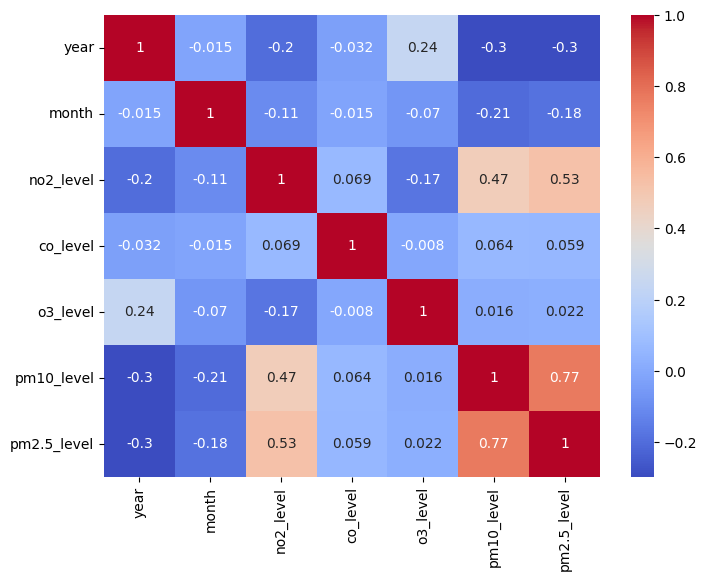

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    "year",
    "month",
    # "so2_level",  # '좋음' 으로 몰려있어서 상관관계 나오지 않음
    "no2_level",
    "co_level",
    "o3_level",
    "pm10_level",
    "pm2.5_level"
]

plt.figure(figsize=(8,6))
sns.heatmap(pol_df_n[cols].corr(), annot=True, cmap="coolwarm")
plt.show()

### 핵심 인사이트
1. 미세먼지(PM10, PM2.5)는 장기적으로 감소 추세를 보인다.
2. PM10과 PM2.5는 강하게 연결된 군집 구조를 가진다.
3. NO₂는 미세먼지 상승과 함께 증가하는 주요 연소 지표이다.
4. 오존(O₃)은 미세먼지와 독립적인 계절성 오염물질이다.
5. 미세먼지는 계절적 영향을 강하게 받는다.

- (추가) no2와 미세먼지 관계:
NO₂와 PM2.5 간의 약 0.5 수준의 양의 상관관계는 두 물질이 동일한 연소 배출원(자동차 배기가스, 산업 연소, 발전소 등)을 공유하기 때문이며, 동시에 NO₂가 2차 생성 미세먼지의 전구물질로 작용하기 때문이다. 대기 중 NO₂는 암모니아(NH₃) 등과 반응하여 질산염(NH₄NO₃)을 형성하고, 이는 PM2.5의 주요 구성 성분 중 하나가 된다. 따라서 NO₂ 농도가 증가하면 2차 화학 반응을 통해 초미세먼지 농도도 함께 상승하는 경향이 나타난다. 이러한 결과는 대기 화학적 생성 메커니즘과 배출 구조가 통계적으로 반영된 것으로 해석할 수 있다.

# 연도별 공해 수치 변화 추이
(단위 무시. 추이만 보는 용)

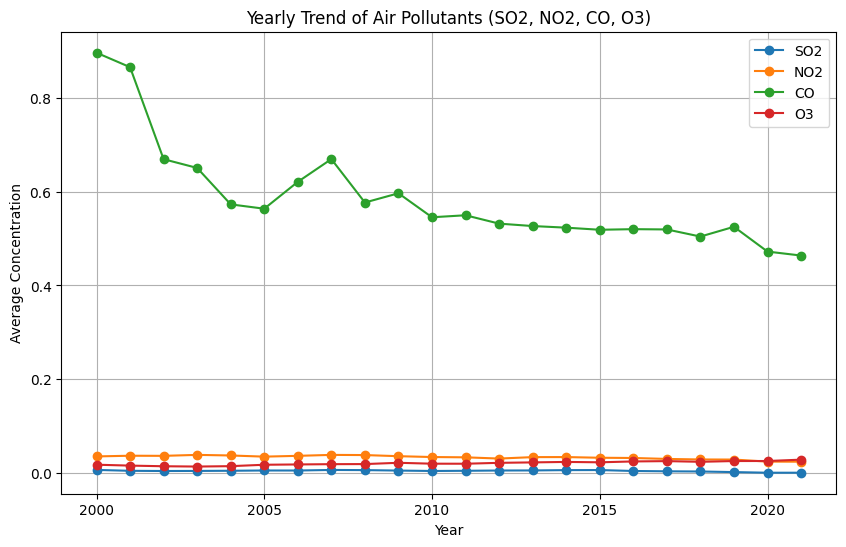

In [29]:
import matplotlib.pyplot as plt

# 연도별 평균 계산
yearly_pollution = pol_df_n.groupby("year")[["so2", "no2", "co", "o3"]].mean()

plt.figure(figsize=(10,6))

plt.plot(yearly_pollution.index, yearly_pollution["so2"], marker="o", label="SO2")
plt.plot(yearly_pollution.index, yearly_pollution["no2"], marker="o", label="NO2")
plt.plot(yearly_pollution.index, yearly_pollution["co"], marker="o", label="CO")
plt.plot(yearly_pollution.index, yearly_pollution["o3"], marker="o", label="O3")

plt.xlabel("Year")
plt.ylabel("Average Concentration")
plt.title("Yearly Trend of Air Pollutants (SO2, NO2, CO, O3)")
plt.legend()
plt.grid(True)

plt.show()

# 해석
SO₂, NO₂, CO, O₃의 연도별 농도 변화는 각 물질의 배출 특성과 대기 화학적 특성 차이로 인해 절대 농도 수준이 크게 다르게 나타난다. 특히 CO는 연소 과정에서 대량으로 발생하고 대기 중 체류 시간이 길어 다른 오염물질보다 높은 농도를 보이며, 반면 SO₂와 NO₂는 상대적으로 낮은 농도 범위를 가진다. 따라서 본 그래프는 오염물질 간 절대 농도 비교보다는 각 물질의 시간적 변화 추세를 파악하는 데 의미가 있으며, 전반적으로 대부분 오염물질이 장기적으로 감소하는 경향을 보인다.
--> 특히 위의 plot은 각 공해별 단위가 다르기 때문에 연도 추이를 보는 것이 목적

## 추가 작업(각 공해별 그래프 플롯 - 단위 무시할 필요 없음)

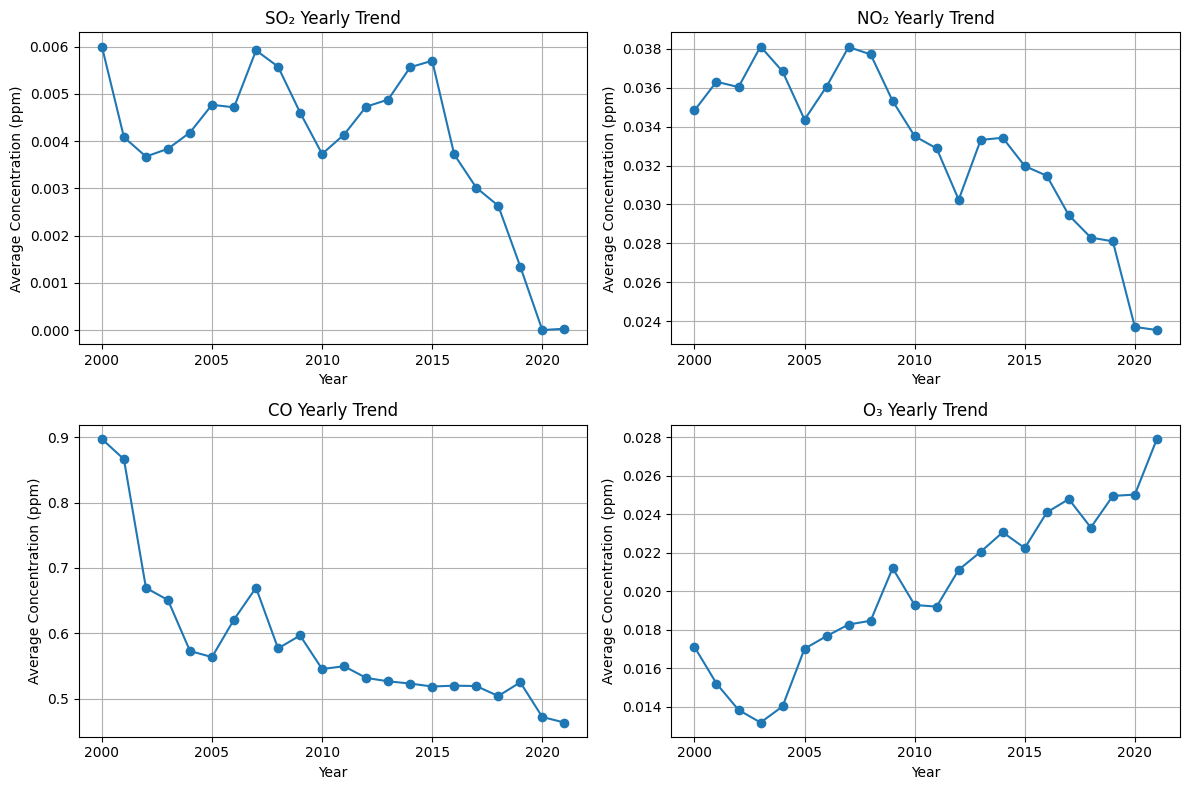

In [30]:
import matplotlib.pyplot as plt

yearly_pollution = pol_df_n.groupby("year")[["so2", "no2", "co", "o3"]].mean()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

pollutants = ["so2", "no2", "co", "o3"]
titles = ["SO₂", "NO₂", "CO", "O₃"]
units = ["ppm", "ppm", "ppm", "ppm"]  # 필요하면 수정

for ax, pol, title, unit in zip(axes.flatten(), pollutants, titles, units):
    ax.plot(yearly_pollution.index, yearly_pollution[pol], marker="o")
    ax.set_title(f"{title} Yearly Trend")
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Average Concentration ({unit})")
    ax.grid(True)

plt.tight_layout()
plt.show()

- **SO₂**: 2000년대 중반 이후 급격한 감소 추세를 보이며 이는 황 함유 연료 규제 강화와 산업·발전 부문의 배출 저감 정책 영향으로 해석된다.
- **NO₂**: 전반적으로 감소 경향을 보이며 차량 배출가스 규제 강화와 친환경 차량 증가 등의 교통 부문 정책 효과가 반영된 것으로 볼 수 있다.
- **CO**: 초기 급감 이후 완만한 감소를 지속하며 이는 연소 효율 개선과 자동차 배출 관리 강화에 따른 결과로 해석된다.
- **O₃**: 장기적으로 증가 추세를 보이는데 이는 NOx 감소로 인한 광화학 반응 변화와 기온 상승 등의 기상 영향이 복합적으로 작용한 결과로 볼 수 있다.

## Accident 데이터 분석

[데이터 출처: Kaggle](https://www.kaggle.com/datasets/seventyfivebyte/seoul-daily-hourly-traffic-accident-status)

In [31]:
AccidentImporter.reset_file()

In [32]:
accident_df = AccidentImporter.import_csv()
accident_df = advanced_day(accident_df)
accident_df.head()

,year,month,day,day_of_year,weekday,accident_cnt,death,fatal,injured,death_rate(%),fatal_rate(%)
0,2017,1,1,1,6,73,2,25,90,2.74,34.25
1,2017,1,2,2,0,82,4,27,92,4.88,32.93
2,2017,1,3,3,1,88,1,25,80,1.14,28.41
3,2017,1,4,4,2,115,1,39,99,0.87,33.91
4,2017,1,5,5,3,103,1,34,111,0.97,33.01


In [33]:
agg_dict = {
    "accident_cnt":"sum",
    "death":"sum",
    "fatal":"sum",
    "injured":"sum"
}

accident_by_weekday = accident_df.groupby(["weekday"], as_index=False).agg(agg_dict)
accident_by_weekday

,weekday,accident_cnt,death,fatal,injured
0,0,16403,153,4704,15270
1,1,16678,132,4778,15710
2,2,17128,125,4855,16248
3,3,17200,134,5040,15930
4,4,18662,133,5402,17494
5,5,17607,111,5109,18446
6,6,13000,109,4074,13970


In [34]:
severity_by_year = (
    accident_df
        .groupby('year')[['death','fatal','injured']]
        .sum()
)

severity_ratio_year = severity_by_year.div(
    severity_by_year.sum(axis=1),
    axis=0
)

severity_ratio_year

,death,fatal,injured
year,,,
2017,0.006984,0.243617,0.749399
2018,0.006152,0.230354,0.763494
2019,0.005061,0.214870,0.780070


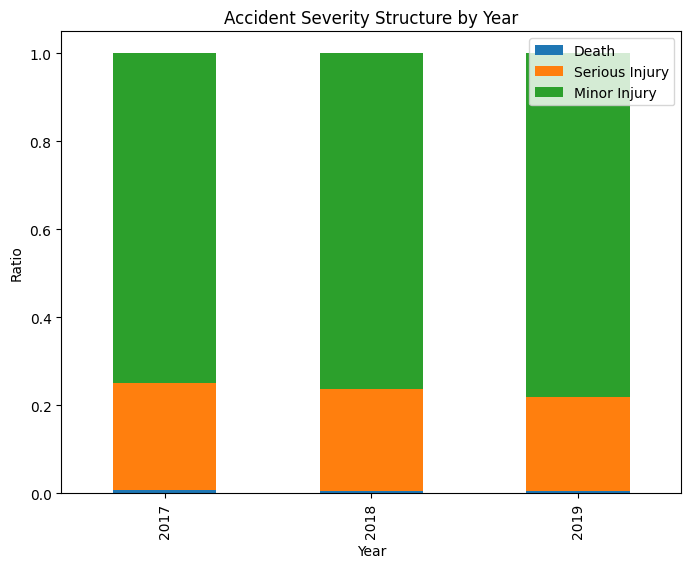

In [35]:
import matplotlib.pyplot as plt

severity_ratio_year.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6)
)

plt.title('Accident Severity Structure by Year')
plt.ylabel('Ratio')
plt.xlabel('Year')
plt.legend(['Death','Serious Injury','Minor Injury'])
plt.show()

<Axes: xlabel='year'>

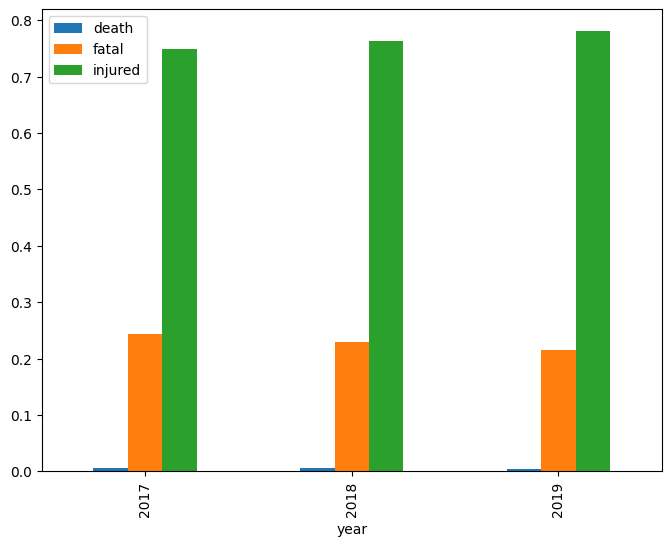

In [36]:
severity_ratio_year.plot(
    kind='bar',
    stacked=False,
    figsize=(8,6)
)

In [37]:
# 연도별 사고 1건당 사망 위험도 계산
fatality_rate = (
    accident_df
        .groupby('year')[['death','accident_cnt']]
        .sum()
)

fatality_rate['death_per_accident'] = (
    fatality_rate['death'] / fatality_rate['accident_cnt']
)

fatality_rate

,death,accident_cnt,death_per_accident
year,,,
2017,343,38625,0.008880
2018,304,38795,0.007836
2019,250,39258,0.006368


In [38]:
# 연도 + 월별 사고 1건당 사망 위험도 계산
fatality_rate_ym = (
    accident_df
        .groupby(['year', 'month'])[['death', 'accident_cnt']]
        .sum()
)

fatality_rate_ym['death_per_accident'] = (
    fatality_rate_ym['death'] / fatality_rate_ym['accident_cnt']
).round(4)

fatality_2017 = fatality_rate_ym.loc[2017]
fatality_2018 = fatality_rate_ym.loc[2018]
fatality_2019 = fatality_rate_ym.loc[2019]

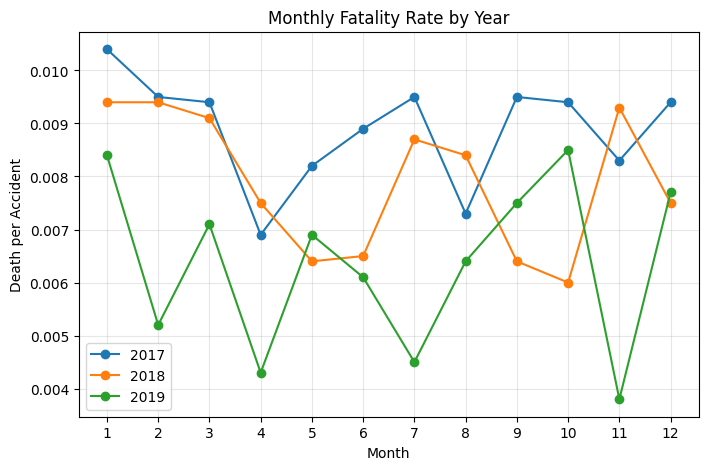

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(
    fatality_2017.index,
    fatality_2017['death_per_accident'],
    marker='o',
    label='2017'
)

plt.plot(
    fatality_2018.index,
    fatality_2018['death_per_accident'],
    marker='o',
    label='2018'
)

plt.plot(
    fatality_2019.index,
    fatality_2019['death_per_accident'],
    marker='o',
    label='2019'
)

plt.xlabel('Month')
plt.ylabel('Death per Accident')
plt.title('Monthly Fatality Rate by Year')
plt.legend()
plt.xticks(range(1,13))
plt.grid(alpha=0.3)

plt.show()

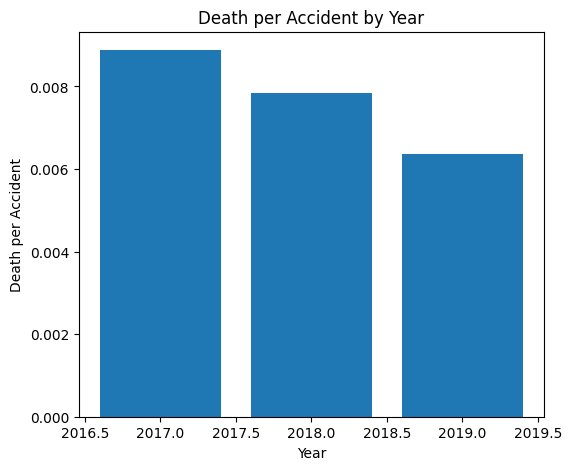

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.bar(
    fatality_rate.index,
    fatality_rate['death_per_accident']
)

plt.title('Death per Accident by Year')
plt.ylabel('Death per Accident')
plt.xlabel('Year')

plt.show()

In [41]:
accident_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           1095 non-null   int64  
 1   month          1095 non-null   int64  
 2   day            1095 non-null   int64  
 3   day_of_year    1095 non-null   int32  
 4   weekday        1095 non-null   int32  
 5   accident_cnt   1095 non-null   int64  
 6   death          1095 non-null   int64  
 7   fatal          1095 non-null   int64  
 8   injured        1095 non-null   int64  
 9   death_rate(%)  1095 non-null   float64
 10  fatal_rate(%)  1095 non-null   float64
dtypes: float64(2), int32(2), int64(7)
memory usage: 85.7 KB


In [42]:
ratio_2017 = (
    accident_df[accident_df['year'] == 2017]
        .groupby('weekday')['death']
        .sum()
)

ratio_2017 = ratio_2017 / ratio_2017.sum()

ratio_2017

weekday
0    0.180758
1    0.128280
2    0.139942
3    0.139942
4    0.166181
5    0.107872
6    0.137026
Name: death, dtype: float64

In [43]:
ratio_2018 = (
    accident_df[accident_df['year'] == 2018]
        .groupby('weekday')['death']
        .sum()
)

ratio_2018 = ratio_2018 / ratio_2018.sum()

ratio_2018

weekday
0    0.174342
1    0.134868
2    0.121711
3    0.171053
4    0.125000
5    0.151316
6    0.121711
Name: death, dtype: float64

In [44]:
ratio_2019 = (
    accident_df[accident_df['year'] == 2019]
        .groupby('weekday')['death']
        .sum()
)

ratio_2019 = ratio_2019 / ratio_2019.sum()

ratio_2019

weekday
0    0.152
1    0.188
2    0.160
3    0.136
4    0.152
5    0.112
6    0.100
Name: death, dtype: float64

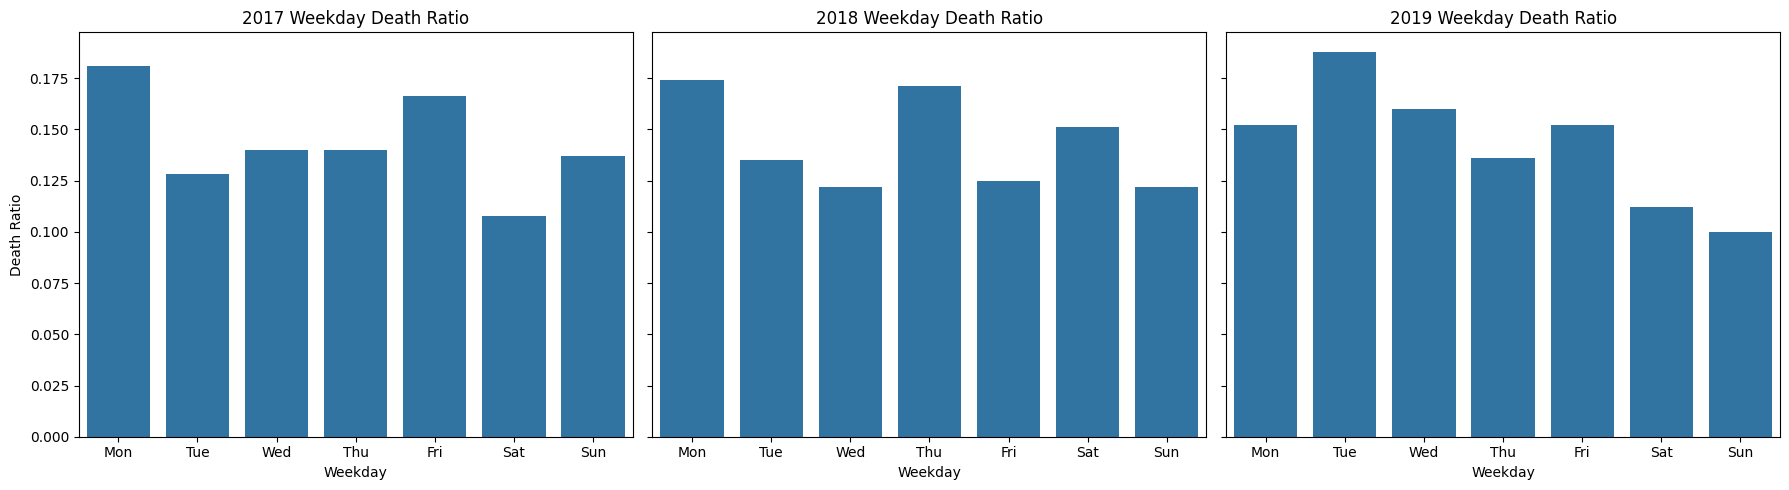

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

ratios = [ratio_2017, ratio_2018, ratio_2019]
years = [2017, 2018, 2019]

weekday_map = {
    0:'Mon', 1:'Tue', 2:'Wed',
    3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'
}

for i in range(3):

    data = ratios[i].copy()
    data.index = data.index.map(weekday_map)

    sns.barplot(
        x=data.index,
        y=data.values,
        ax=axes[i]
    )

    axes[i].set_title(f'{years[i]} Weekday Death Ratio')
    axes[i].set_xlabel('Weekday')

axes[0].set_ylabel('Death Ratio')

plt.tight_layout()
plt.show()

In [46]:
accident_df

,year,month,day,day_of_year,weekday,accident_cnt,death,fatal,injured,death_rate(%),fatal_rate(%)
0,2017,1,1,1,6,73,2,25,90,2.74,34.25
1,2017,1,2,2,0,82,4,27,92,4.88,32.93
2,2017,1,3,3,1,88,1,25,80,1.14,28.41
3,2017,1,4,4,2,115,1,39,99,0.87,33.91
4,2017,1,5,5,3,103,1,34,111,0.97,33.01
...,...,...,...,...,...,...,...,...,...,...,...
1090,2019,12,27,361,4,94,0,27,88,0.00,28.72
1091,2019,12,28,362,5,94,0,27,105,0.00,28.72
1092,2019,12,29,363,6,78,1,26,87,1.28,33.33
1093,2019,12,30,364,0,91,1,19,93,1.10,20.88


<Axes: >

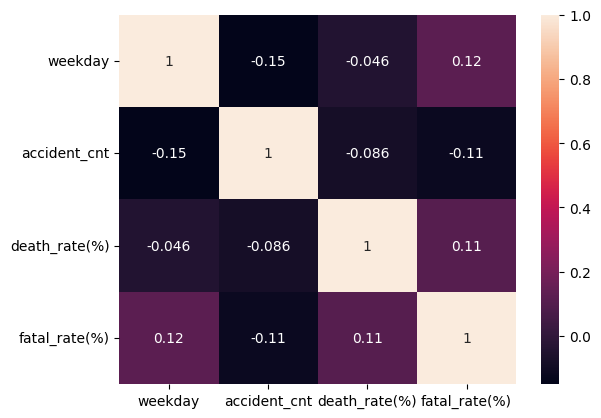

In [47]:
target_cols = ["weekday", "accident_cnt", 'death_rate(%)', 'fatal_rate(%)']
heat_df = accident_df[target_cols]
sns.heatmap(heat_df.corr(), annot=True)

## 연관 데이터 분석

In [48]:
# 전처리된 데이터프레임들을 import
df_prep_weather = WeatherImporter.import_csv()
df_prep_pollution = PollutionImporter.import_csv()
df_prep_accident = AccidentImporter.import_csv()

# 3개의 DataFrame을 join
keys = ["year", "month", "day"]
df_merged = pd.merge(df_prep_weather, df_prep_pollution, on=keys, how="inner")
df_merged = pd.merge(df_merged, df_prep_accident, on=keys, how="inner")

# day_of_year과 weekday 더함
df_merged = advanced_day(df_merged)
df_merged.head()

,year,month,day,day_of_year,weekday,temp,humidity,cloudy,precip,snow,...,pm10,pm10_level,pm2.5,pm2.5_level,accident_cnt,death,fatal,injured,death_rate(%),fatal_rate(%)
0,2017,1,1,1,6,2.722222,72.0,1,0.000,0.0,...,77.33,1,56.78,2,73,2,25,90,2.74,34.25
1,2017,1,2,2,0,5.333333,73.6,1,0.012,0.0,...,110.66,2,78.61,3,82,4,27,92,4.88,32.93
2,2017,1,3,3,1,1.388889,63.6,0,0.000,0.0,...,78.60,1,51.50,2,88,1,25,80,1.14,28.41
3,2017,1,4,4,2,2.944444,60.1,1,0.000,0.0,...,54.88,1,34.36,1,115,1,39,99,0.87,33.91
4,2017,1,5,5,3,3.333333,53.5,1,0.000,0.0,...,35.85,1,22.22,1,103,1,34,111,0.97,33.01


In [49]:
# heatmap 제공 함수
def draw_corr_heatmap(df, cols, title):
    corr_dat = df[cols].corr()
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        corr_dat,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

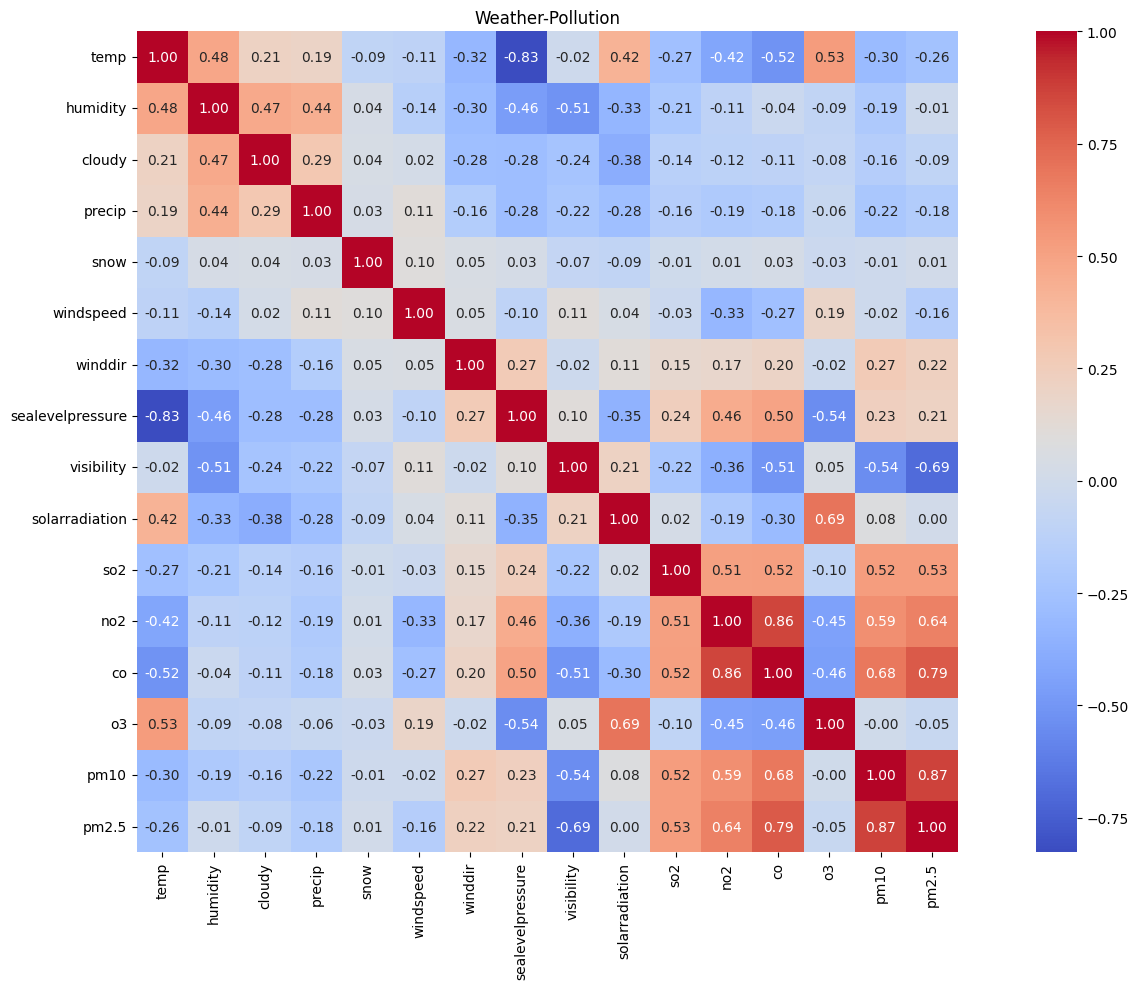

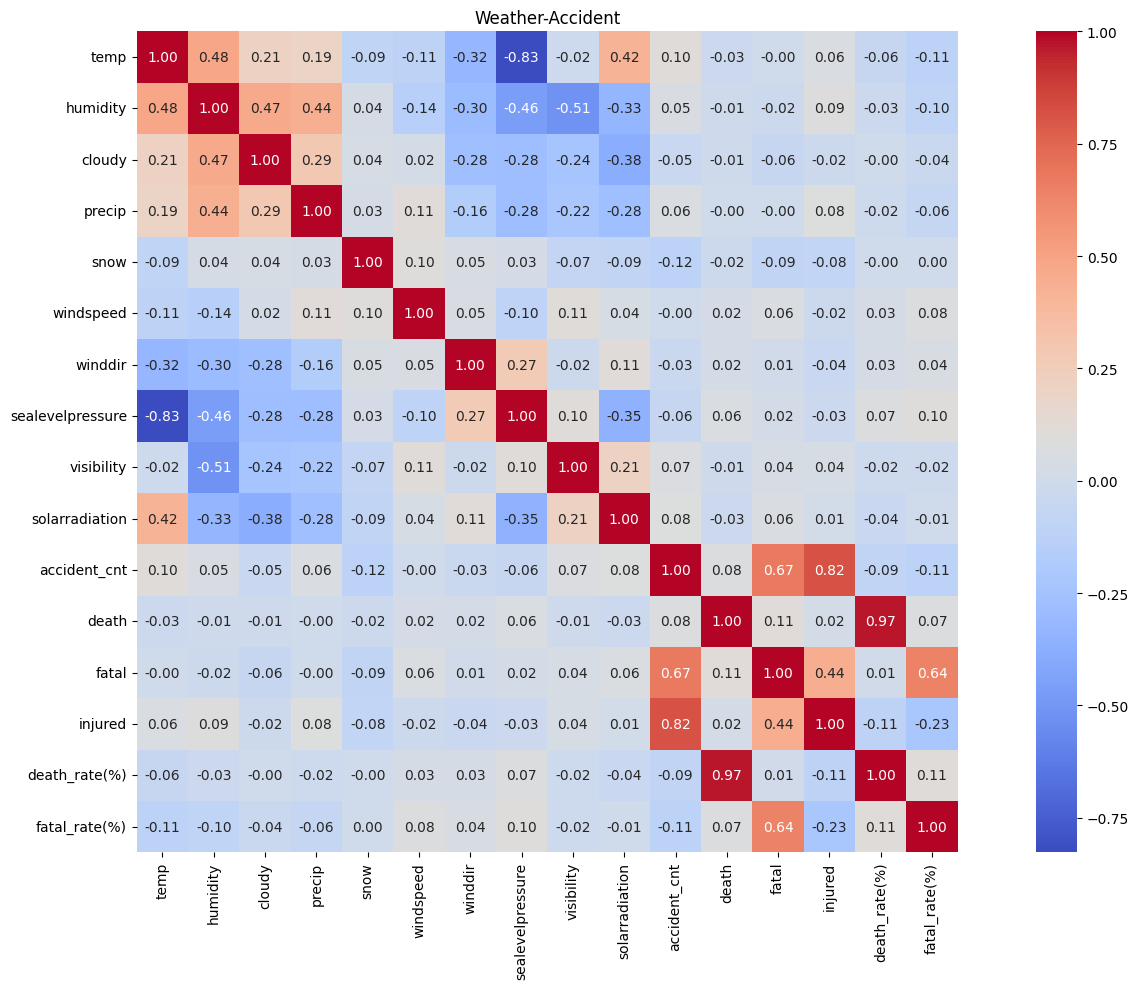

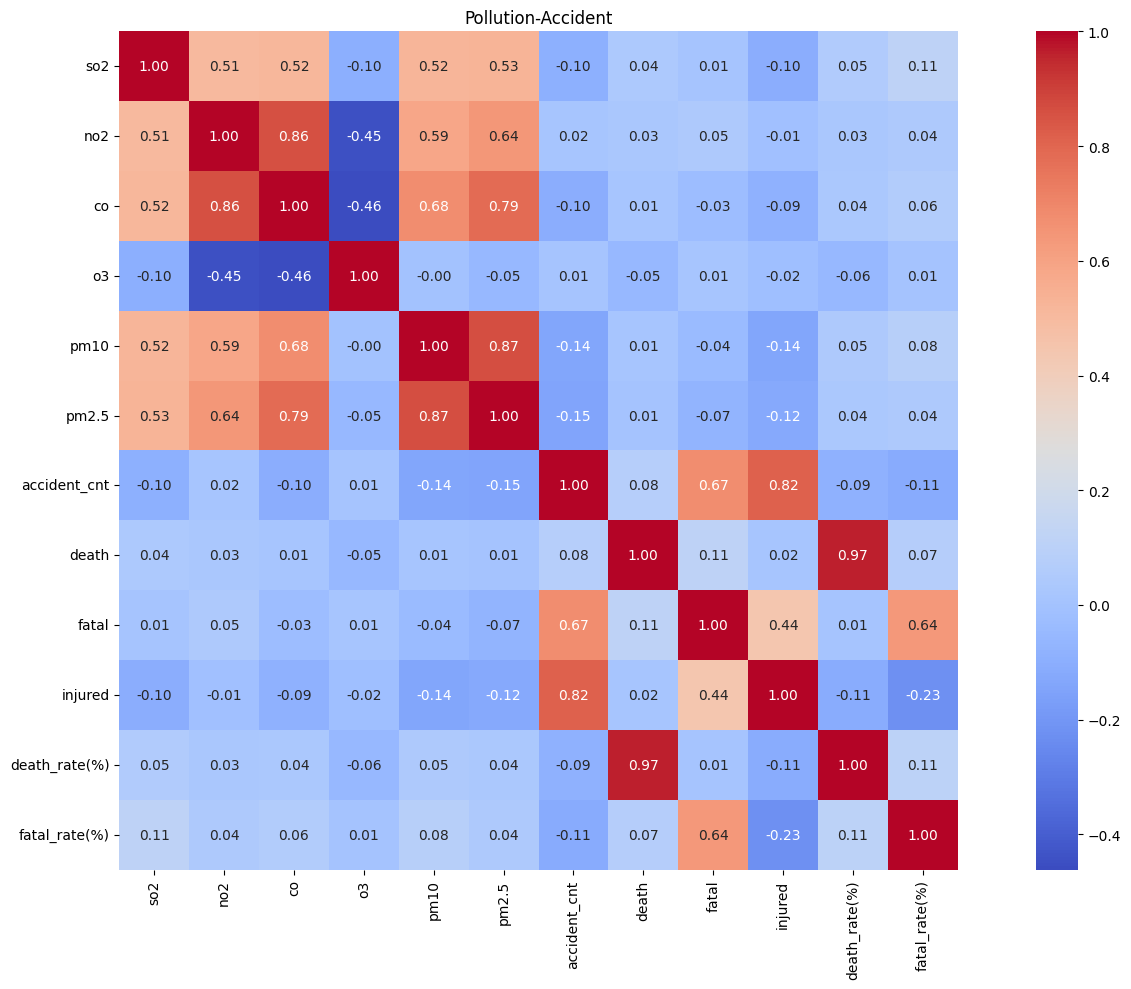

In [50]:
# 각 데이터간의 연관 경향성을 보기 위한 heatmap
weather_cols = ['temp', 'humidity', 'cloudy', 'precip', 'snow', 'windspeed', 'winddir', 'sealevelpressure', 'visibility', 'solarradiation']
pollution_cols = ["so2", "no2", "co", "o3", "pm10", "pm2.5"]
accident_cols = ['accident_cnt', 'death', 'fatal', 'injured', 'death_rate(%)', 'fatal_rate(%)']

draw_corr_heatmap(df_merged, weather_cols + pollution_cols, "Weather-Pollution")
draw_corr_heatmap(df_merged, weather_cols + accident_cols, "Weather-Accident")
draw_corr_heatmap(df_merged, pollution_cols + accident_cols, "Pollution-Accident")

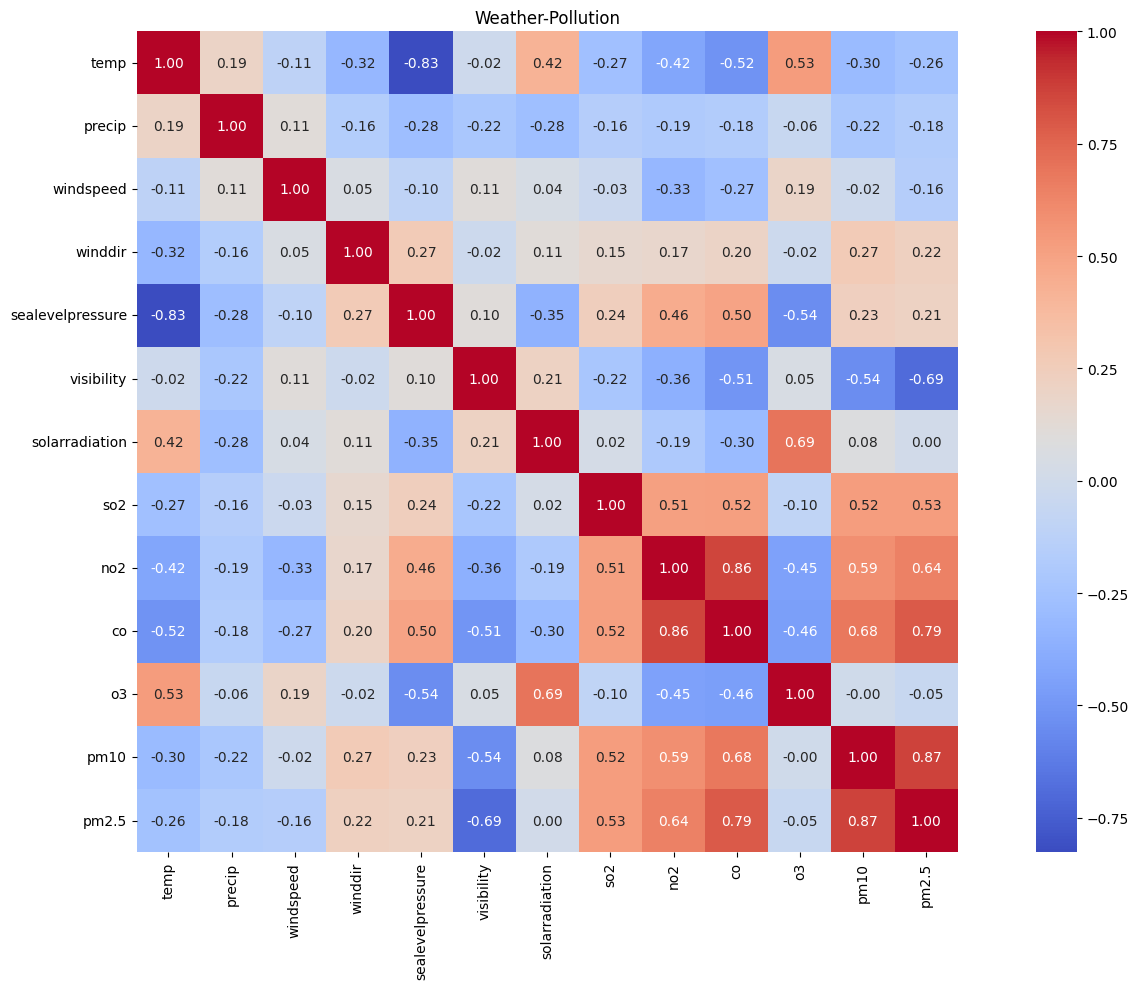

In [51]:
wp_cols = ["temp", "precip", 'windspeed', 'winddir', 'sealevelpressure', 'visibility', 'solarradiation', "so2", "no2", "co", "o3", "pm10", "pm2.5"]
draw_corr_heatmap(df_merged, wp_cols, "Weather-Pollution")

### 날씨 공해 상관 계수 heatmap
- temp <> 오염원 간의 0.2~0.5의 높은 상관 계수를 확인할 수 있음
- precip(강수량)의 경우는 다른 오염원과는 0.2 정도의 음의 상관 계수를 가지지만 O3와는 낮은 상관 계수를 가지는 모습을 보였다
- windspeed, sealevelpressure <> NO2, CO, O3와는 높은 관계성을 가지지만 다른 오염원과는 상대적으로 낮은 상관계수를 확인할 수 있었다
- visibility(가시성)은 O3를 제외한 다른 오염원들과는 높은 상관 계수를 보여주었다
- solarradiation <> O3는 매우 높은 상관 계수를 확인할 수 있었다

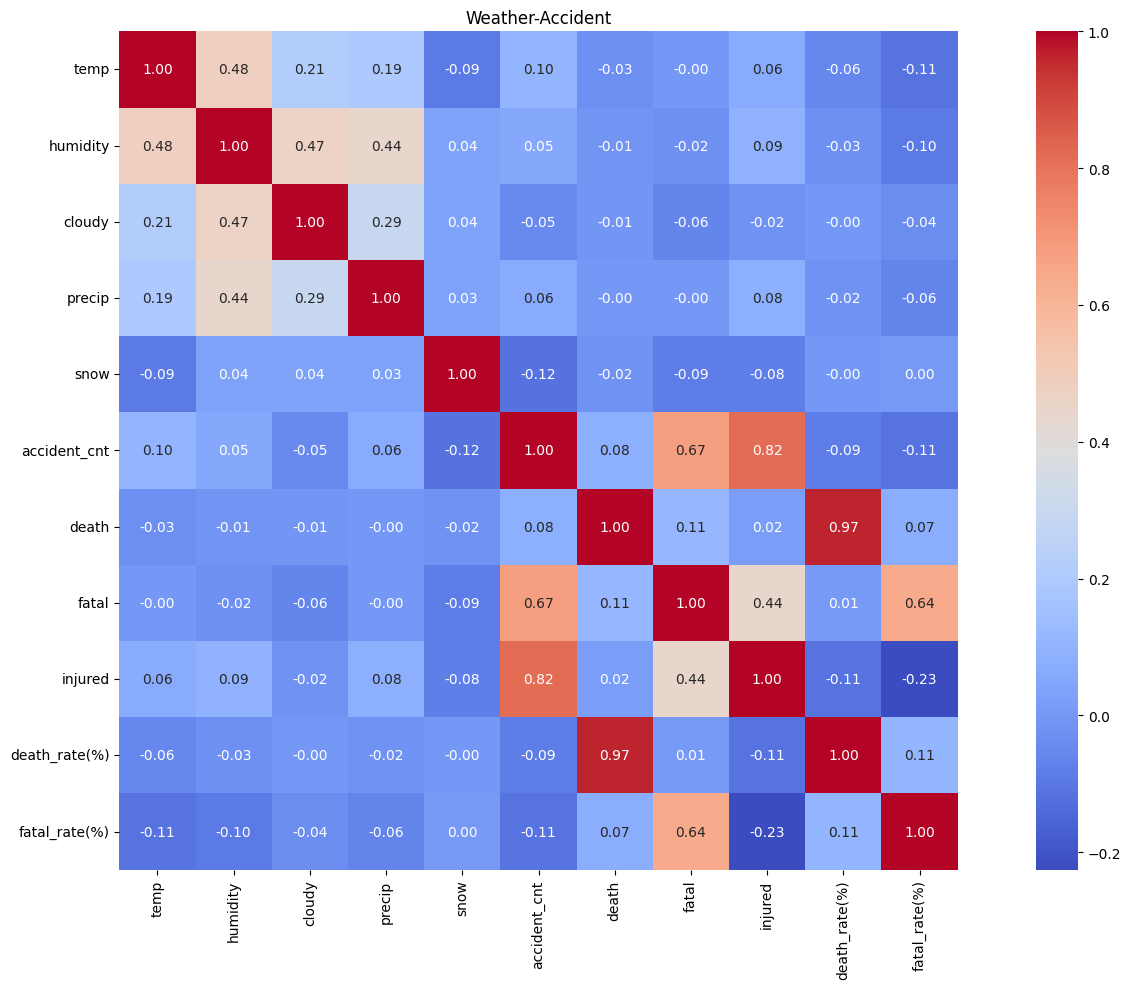

In [52]:
wa_cols = ['temp', 'humidity', 'cloudy', 'precip', 'snow', 'accident_cnt', 'death', 'fatal', 'injured', 'death_rate(%)', 'fatal_rate(%)']
draw_corr_heatmap(df_merged, wa_cols, "Weather-Accident")

### 날씨 <-> 사고 상관 계수 heatmap
- precip, snow 등의 교통사고와 관련이 높을 것 같은 데이터도 사고량에 낮은 상관계수를 보여줌
- temp와 humidity가 death_rate와 humidity 비교적 높은 상관계수를 확인할 수 있었음
- 노면의 젖음 유무가 중요할 수 있기 때문에 상관계수가 아닌 scatterplot을 통한 추가적인 확인이 필요해 보임


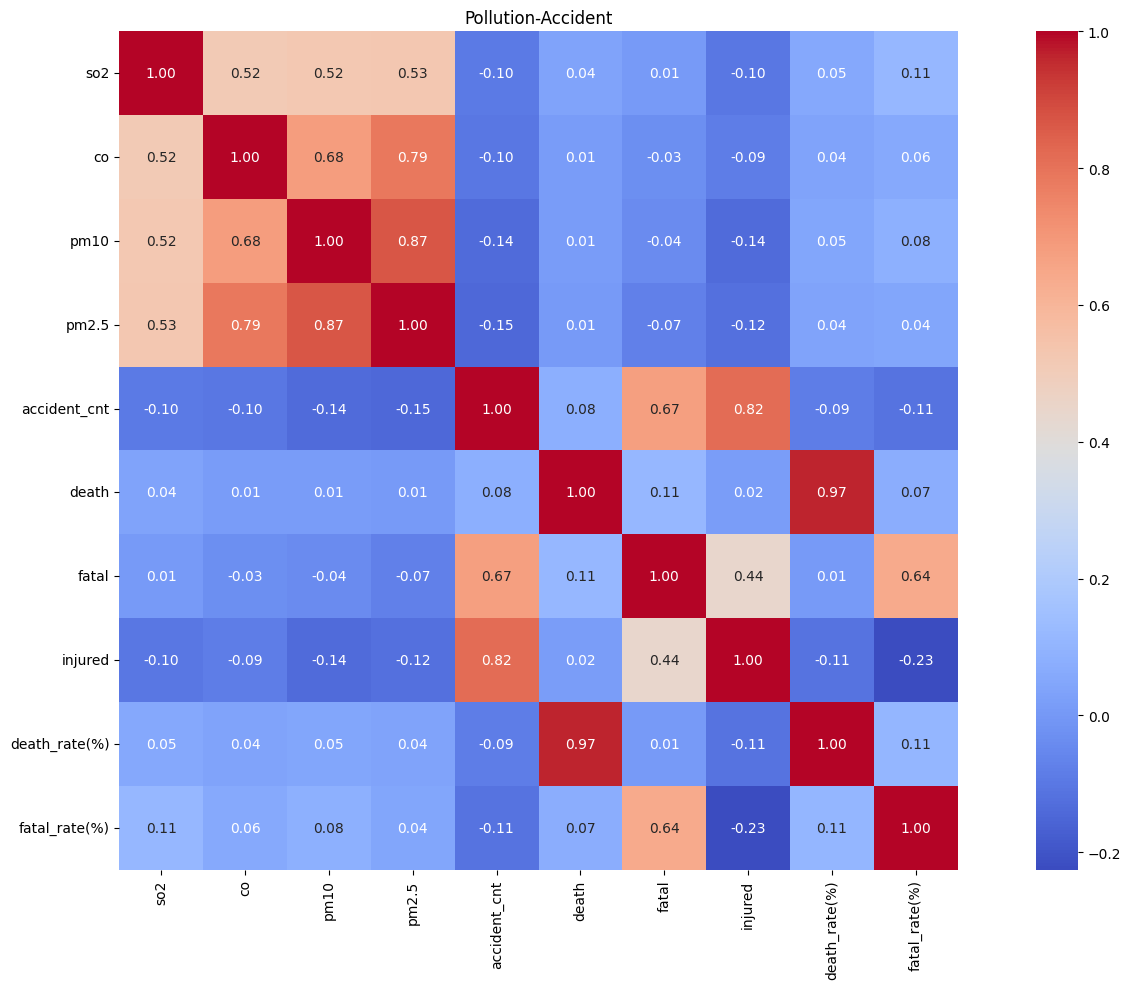

In [53]:
pa_cols = ["so2", "co", "pm10", "pm2.5", 'accident_cnt', 'death', 'fatal', 'injured', 'death_rate(%)', 'fatal_rate(%)']
draw_corr_heatmap(df_merged, pa_cols, "Pollution-Accident")

### 공해 <-> 사고 상관 계수 heatmap
- SO2와 CO는 accident_cnt와 injured, fatal_rate에 낮은 연관성을 보여주었다
- pm10, pm2.5 역시 accident_cnt와 injured에 낮은 연관성 보여주었다

In [54]:
# scatterplot 함수
def draw_scatter(df, col1, col2):
    x = df[col1]
    y = df[col2]

    plt.figure()
    plt.scatter(x, y)

    coef = np.polyfit(x, y, 1)
    poly_fn = np.poly1d(coef)

    x_sorted = np.sort(x)
    plt.plot(x_sorted, poly_fn(x_sorted))

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f"{col1} vs {col2} (with trend line)")
    plt.tight_layout()
    plt.show()

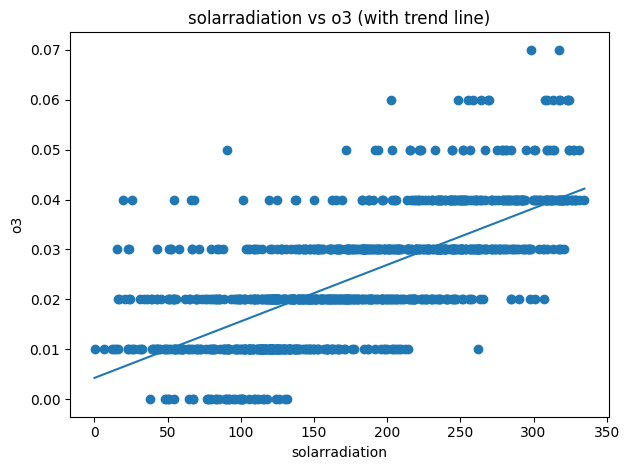

In [55]:
draw_scatter(df_merged, "solarradiation", "o3")

### 오존의 특징

오존은 직접 배출되는 물질이 아니라

태양광(특히 자외선)에 의해 생성되는 2차 오염물질로, solarradiation의 값이 높을수록 증가하는 양의 상관 관계를 보여준다.

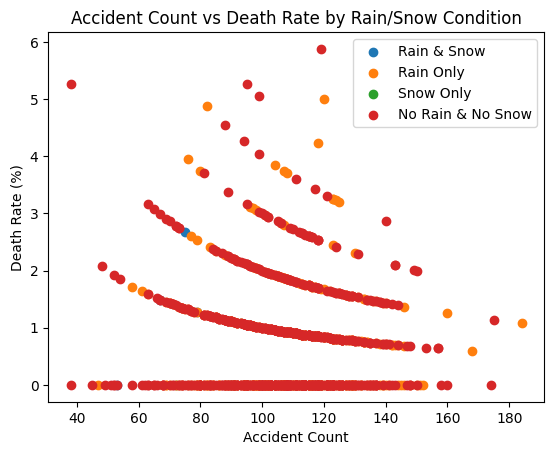

In [56]:
# df_merged 사용
df = df_merged.copy()

# 조건별 마스크
cond1 = (df["precip"] > 0) & (df["snow"] > 0)    # 비O, 눈O
cond2 = (df["precip"] > 0) & (df["snow"] == 0)   # 비O, 눈X
cond3 = (df["precip"] == 0) & (df["snow"] > 0)   # 비X, 눈O
cond4 = (df["precip"] == 0) & (df["snow"] == 0)  # 비X, 눈X

plt.figure()

plt.scatter(df.loc[cond1, "accident_cnt"],
            df.loc[cond1, "death_rate(%)"],
            label="Rain & Snow")

plt.scatter(df.loc[cond2, "accident_cnt"],
            df.loc[cond2, "death_rate(%)"],
            label="Rain Only")

plt.scatter(df.loc[cond3, "accident_cnt"],
            df.loc[cond3, "death_rate(%)"],
            label="Snow Only")

plt.scatter(df.loc[cond4, "accident_cnt"],
            df.loc[cond4, "death_rate(%)"],
            label="No Rain & No Snow")

plt.xlabel("Accident Count")
plt.ylabel("Death Rate (%)")
plt.title("Accident Count vs Death Rate by Rain/Snow Condition")
plt.legend()
plt.show()

### Accident Count와 눈, 비와의 연관 관계 Scatter Plot
- Accident Count와 Death Rate는 관계성을 보여준다
- 하지만 눈, 비와는 연관성을 찾아보기 힘들었다

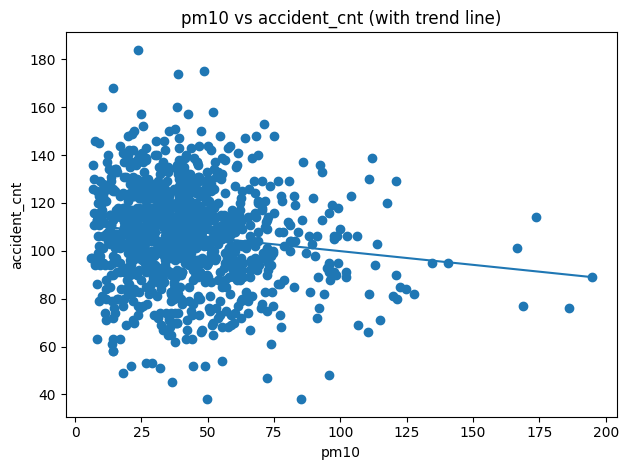

In [57]:
draw_scatter(df_merged, "pm10", "accident_cnt")

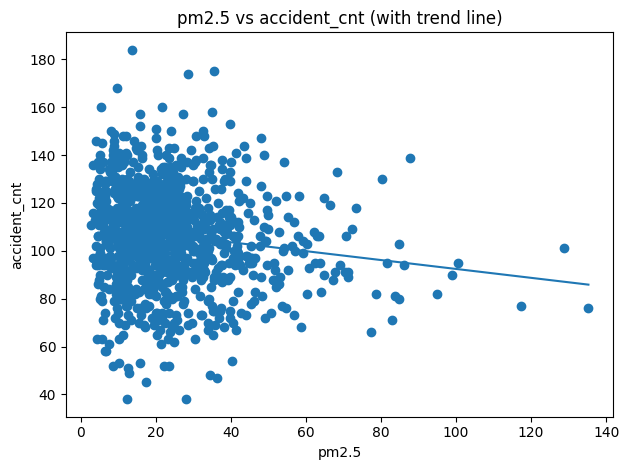

In [58]:
draw_scatter(df_merged, "pm2.5", "accident_cnt")